<a href="https://colab.research.google.com/github/NMashalov/2023_OpenMipt_course/blob/main/lesson4/%D0%A1%D0%B5%D0%BC%D0%B8%D0%BD%D0%B0%D1%80%204%20-%20%D1%81%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F%2C%20U-Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <a href="https://miptstats.github.io/courses/ad_mipt.html">Phystech@DataScience</a>
## Семинар 4
## Сегментация


In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, random_split
from torch.nn import BCEWithLogitsLoss
import numpy as np

import torchvision.transforms as tt
from PIL import Image
import os

import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython.display import clear_output # для отчистки экрана

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
device = f"cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(device)

cuda


### 1. Релизация метрики IoU
Реализуйте метрику IoU. Она вам понадобится далее для оценивания результатов предсказания модели.

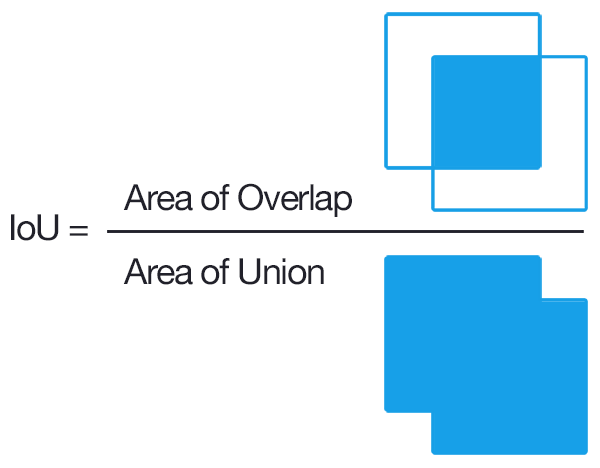

In [90]:
def iou(predicted_mask_batch, target_mask_batch):
    """ Считает среднее IoU для всех элементов батча
    predicted_mask_batch - булев тензор размерности (batch_size, 1, H, W) - определяет предсказанную принадлежность пикселя к классу 1
    target_mask_batch - булев тензор размерности (batch_size, 1, H, W) - определяет реальную принадлежность пикселя к классу 1
    """
    # Площадь пересечения в пикселях для всех элементов батча
    intersection = predicted_mask_batch & target_mask_batch
    # Площадь объединения в пикселях для всех элементов батча
    union =  predicted_mask_batch | target_mask_batch
    batch_size = union.size(0)
    # Посчитайте IoU для каждого элемента батча, а затем усредните по батчу
    iou = torch.mean(intersection.view(batch_size,-1).sum(1) / union.view(batch_size,-1).sum(1))
    return iou

In [91]:
predicted_mask_batch = torch.ones((1, 1, 10, 10)).bool()
target_mask_batch =  torch.ones((1, 1, 10, 10)).bool()
print(iou(predicted_mask_batch, target_mask_batch))
assert torch.allclose(iou(predicted_mask_batch, target_mask_batch), torch.tensor(1.0))

tensor(1.)


### 2. Сегментация изображений

Попробуем написать неглубокую сеть и сегментировать ногти на изображения ладоней. Для этого напишем энкодер, который будет применять к входному изображению несколько свёрток, а затем напишем декодер, который по скрытому представлению будет разворачивать картинку с помощью обратных свёрток.

Загрузите скачанный [архив](https://drive.google.com/u/0/uc?id=1Irfwzmx7b1m2jwd2lHGDO1vXOgUeBBb0&export=download) `archive.zip` в Colab.

In [7]:
import gdown # библиотека для скачивания файлов с гугл-диска

gdown.download('https://drive.google.com/u/0/uc?id=1Irfwzmx7b1m2jwd2lHGDO1vXOgUeBBb0&export=download')

Downloading...
From: https://drive.google.com/u/0/uc?id=1Irfwzmx7b1m2jwd2lHGDO1vXOgUeBBb0&export=download
To: /content/archive.zip
100%|██████████| 32.5M/32.5M [00:01<00:00, 24.8MB/s]


'archive.zip'

In [8]:
! unzip archive.zip # разархивируем наши данные

Archive:  archive.zip
   creating: archive/
  inflating: __MACOSX/._archive      
   creating: archive/images/
  inflating: __MACOSX/archive/._images  
   creating: archive/nails_segmentation/
  inflating: __MACOSX/archive/._nails_segmentation  
  inflating: archive/Copy_of_[hw]gan.ipynb  
  inflating: __MACOSX/archive/._Copy_of_[hw]gan.ipynb  
   creating: archive/labels/
  inflating: __MACOSX/archive/._labels  
  inflating: archive/hw_segmentation.ipynb  
  inflating: __MACOSX/archive/._hw_segmentation.ipynb  
  inflating: archive/images/d97db2d2-18ff-456d-8d85-23bfb7109aef.jpg  
  inflating: __MACOSX/archive/images/._d97db2d2-18ff-456d-8d85-23bfb7109aef.jpg  
  inflating: archive/images/bf93c2e2-7b5f-4108-ae85-4ef68564d418.jpg  
  inflating: __MACOSX/archive/images/._bf93c2e2-7b5f-4108-ae85-4ef68564d418.jpg  
  inflating: archive/images/34404E67-4BB8-432E-863E-C1BEF5EB37E0.jpg  
  inflating: __MACOSX/archive/images/._34404E67-4BB8-432E-863E-C1BEF5EB37E0.jpg  
  inflating: archive/im

Посмотрим на наши данные. Для этого напишем класс датасета:

In [10]:
class NailsDataset(torch.utils.data.Dataset):
    def __init__(self, root, ids=None):
        # выполняем отнаследованную часть функции инициализации
        super(NailsDataset, self).__init__()

        transform = tt.Compose([
            tt.Resize((128,128)),
            tt.ToTensor()
        ]) # приведём все картинки к одному размеру (128, 128) и переведём их в тензоры

        if ids is not None:
            imgs_files = np.array(os.listdir(f'{root}/images'))[ids] # считаем список файлов изображений
            msks_files = np.array(os.listdir(f'{root}/labels'))[ids] # считаем список файлов масок

        else:
            imgs_files = os.listdir(f'{root}/images')
            msks_files = os.listdir(f'{root}/labels')

        # откроем изображения как PIL картинки в формате RGB и применим трансформацию
        self.imgs = [transform(Image.open(f'{root}/images/{file}').convert('RGB'))
                        for file in imgs_files]

        # откроем маски как PIL картинки в формате ч/б и применим трансформацию
        self.msks = [transform(Image.open(f'{root}/labels/{file}').convert('L'))
                        for file in msks_files]

    def __len__(self):
        return len(self.imgs) # возвращает размер датасета

    def __getitem__(self, id):
        # возвращает картинку и соответсвующую ей маску в виде тензоров
        return self.imgs[id], self.msks[id]

In [11]:
root = '/content/archive'

ids = np.arange(0, len(os.listdir(f'{root}/images')))

train_ids, test_ids = np.split(np.random.permutation(ids),
                               [int(0.8 * len(ids))])

In [15]:
train_data = NailsDataset(root,ids=train_ids) # создадим тренировочный датасет
test_data = NailsDataset(root,ids=test_ids) # создадим валидационный датасет

Сколько изображений в каждом из полученных датасетов?

In [16]:
len(train_data), len(test_data)

(41, 11)

**Ответ**:

Визуализируем изображения и соответствующие маски.

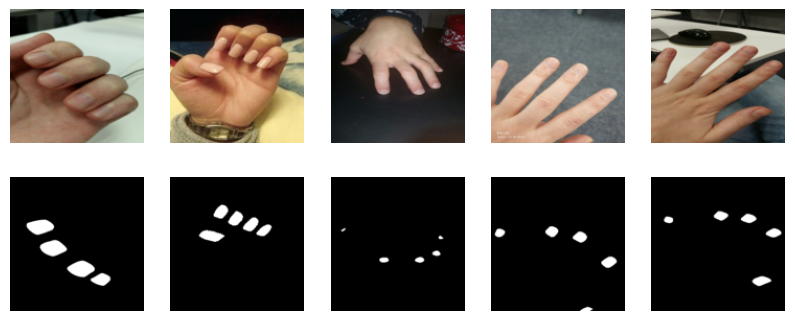

In [17]:
plt.figure(figsize=(10, 4))

for i in range(5):
    plt.subplot(2, 5, i + 1)
    # приводим тензор в numpy.ndarray
    # переставляем первое измерение каналов на последнее мето для отрисовки в plt
    plt.imshow(test_data[i][0].detach().cpu().numpy().transpose(1, 2, 0))
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    # приводим тензор в numpy.ndarray
    # сплющиваем его для отображения в ч/б формате
    plt.imshow(test_data[i][1].detach().cpu().squeeze(0).numpy(), cmap='gray')
    plt.axis('off')

plt.show()

Теперь мы, наконец, готовы перейти к написанию энкодера!

Напишем энкодер с тремя слоями свёрток, на каждом слое будем уменьшать вдвое размер изображения.

*Подсказка: для получения нужных размеров изображений подберите подходящие разумные значения размера фильтра, padding и stride.*

In [33]:
class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.conv1 = torch.nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,stride=2,padding=1,),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        ) # на вход получаем изображение 128x128x3, на выходе после свертки, функции активации и батч-нормализации - 64x64x32

        self.conv2 = torch.nn.Sequential(
            nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        ) # на вход получаем изображен 64x64x32, на выходе после свертки, функции активации и батч-нормализации - 32x32x64

        self.conv3 = torch.nn.Sequential(
            nn.Conv2d(64,128,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        ) # на вход получаем изображен 32x32x64, на выходе после свертки, функции активации и батч-нормализации - 16x16x128

    def forward(self, x):
        x = self.conv1(x) # 64 х 64
        x = self.conv2(x) # 32 х 32
        x = self.conv3(x) # 16 х 16
        return x

Посмотрим на работу нашего энкодера на примере.

In [34]:
x = train_data[0][0].unsqueeze(0)

In [35]:
enc = Encoder()

z = enc(x)
z.shape

torch.Size([1, 128, 16, 16])

С помощью операции обратной свёртки напишем декодер из трёх слоёв, на каждом из которых размер картинки на выходе будет соответствовать картинке в энкодере. Не забудем добавить нормализацию как в обычной сверточной сети. На выходе последнего слоя добавим сигмоиду для дальнейшего подсчёта бинарной крсс-энтропии.

In [50]:
class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.convt1 = torch.nn.Sequential(
            nn.ConvTranspose2d(128,64, kernel_size=2, stride=2),
            torch.nn.ReLU(),
            torch.nn.LazyBatchNorm2d()
        ) # 16x16x128 -> 32x32x64

        self.convt2 = torch.nn.Sequential(
            nn.ConvTranspose2d(64,32, kernel_size=2, stride=2),
            torch.nn.ReLU(),
            torch.nn.LazyBatchNorm2d()
        )  # 32x32x64 -> 64x64x32

        self.convt3 = torch.nn.Sequential(
            nn.ConvTranspose2d(32,1, kernel_size=2, stride=2),
            torch.nn.Sigmoid()
        )  # 64x64x32 -> 128x128x1

    def forward(self, z, test=False):
        z = self.convt1(z)
        if test:
            print(z.shape)

        z = self.convt2(z)
        if test:
            print(z.shape)

        z = self.convt3(z)
        if test:
            print(z.shape)

        return z

Проверяем работу.

In [51]:
dec = Decoder()

dec(z, test=True);

torch.Size([1, 64, 32, 32])
torch.Size([1, 32, 64, 64])
torch.Size([1, 1, 128, 128])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Соединяем всё в одну сеть и запустим процесс обучения.

In [52]:
class Segmentation(torch.nn.Module):
    def __init__(self):
        super(Segmentation, self).__init__()
        self.enc = Encoder()
        self.dec = Decoder()

    def forward(self, x):
        z = self.enc(x)
        res = self.dec(z)
        return res

In [54]:
model = Segmentation() # создаём экземпляр модели
model = model.to(device) # перемещаем модель

Поскольку выход сети будет говорить для каждого пикселя вероятность быть частью маски (насколько пиксель белый), то в качестве функции потерь возьмём попиксельную кросс-энтропию.

In [55]:
lr = 1e-3

# создаём оптимизатор
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

# задаём функцию потерь
criterion = nn.BCELoss()

Напишем функцию для визуализации процесса обучения. Она будет выводить три ряда картинок: изображение, его маску и предсказанную моделью маску.

In [56]:
def show_res(res, epoch, max_epoch):
    """
    Отображение процесса обучения

    res - предсказанные маски
    epoch - текущая эпоха
    max_epoch - всего эпох
    """

    plt.figure(figsize=(6, 4))
    for i in range(5):
        plt.subplot(3, 5, i + 1)
        # рисуем картинку
        plt.imshow(test_data[i][0].detach().cpu().numpy().transpose(1, 2, 0))
        plt.axis('off')

        plt.subplot(3, 5, i + 6)
        # рисуем маску
        plt.imshow(test_data[i][1].detach().cpu().squeeze(0).numpy(), cmap='gray')
        plt.axis('off')

        plt.subplot(3, 5, i + 11)
        # рисуем  предсказанную маску
        plt.imshow(res[i].detach().cpu().squeeze(0).numpy(), cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Epoch {epoch + 1}/{max_epoch}')
    plt.show()

In [57]:
def plot_loss_iou(train_loss, val_loss, train_iou, val_iou):
    fig, ax = plt.subplots(figsize=(12, 6), ncols=2)
    ax[0].set_title('Loss on train and validation')

    ax[0].plot(train_loss, label='train')
    ax[0].plot(val_loss, label='test')

    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].set_title('IoU on train and validation')

    ax[1].plot(train_iou, label='train')
    ax[1].plot(val_iou, label='test')

    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('IoU')

    plt.legend()
    plt.show()

Напишем самую главную функцию, отвечающую за наш процесс обучения, и запустим обучение на 35 эпох.

In [96]:
def train_loop(model, test_data,
               train_dataloader, test_dataloader, max_epoch=10):
    pbar = tqdm(range(max_epoch),
                desc=f'train_loss=nan, val_loss=nan')

    train_losses = []
    val_losses = []
    train_iou = []
    val_iou = []

    for epoch in pbar:
        model.train() # переводим модель в режим обучения
        train_loss = []
        train_iou_ = []

        for x, y in train_dataloader:
            x = x.to(device) # переносим данные на видеокарту
            y = y.to(device)

            predicted_proba = model(x) # запускаем модель

            loss = criterion(predicted_proba,y) # считаем лосс
            train_loss.append(loss.item())

            predicted_mask = predicted_proba > 0.5
            target_mask = y > 0.5
            batch_iou = iou(predicted_mask,target_mask).detach().cpu()
            train_iou_.append(batch_iou)

            # СДЕЛАЙТЕ ШАГ ОПТИМИЗАЦИИ
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_losses.append(np.mean(train_loss))
        train_iou.append(np.mean(train_iou_))

        model.eval() # переводим модель в режим инференса
        val_loss = []
        val_iou_ = []

        with torch.no_grad(): # не накпливаем градиенты
            for x, y in test_dataloader:
                x = x.to(device) # переносим данные на видеокарту
                y = y.to(device)

                # ПОСЧИТАЙТЕ ЛОСС И IOU на валидации
                predicted_proba = model(x)

                predicted_mask = predicted_proba > 0.5
                target_mask = y > 0.5

                loss = criterion(predicted_proba,y).item() # считаем лосс

                predicted_mask = predicted_proba > 0.5
                target_mask = y > 0.5
                batch_iou = iou(predicted_mask,target_mask).detach().cpu()
                val_loss.append(loss)
                val_iou_.append(batch_iou)


            val_losses.append(np.mean(val_loss))
            val_iou.append(np.mean(val_iou_))

            res = []
            if (epoch % 5 == 0) or (epoch == max_epoch - 1):
                for i in range(5):
                    # предсказываем маски для первых пяти картинок
                    res.append(model(test_data[i][0].unsqueeze(0).cuda()).squeeze(0))

                clear_output(wait=True)
                show_res(res, epoch, max_epoch) # отрисовываем результат

        pbar.set_description(f'train_loss={np.mean(train_loss)}, val_loss={np.mean(val_loss)}, train_iou={np.mean(train_iou_)}, val_iou={np.mean(val_iou_)}')

    return train_losses, val_losses, train_iou, val_iou

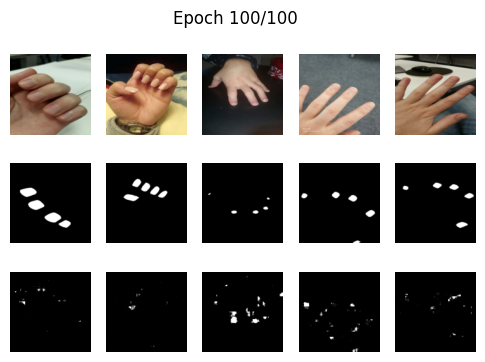

train_loss=0.012442771655817827, val_loss=0.23119737207889557, train_iou=0.9775744080543518, val_iou=0.18870168924331665: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


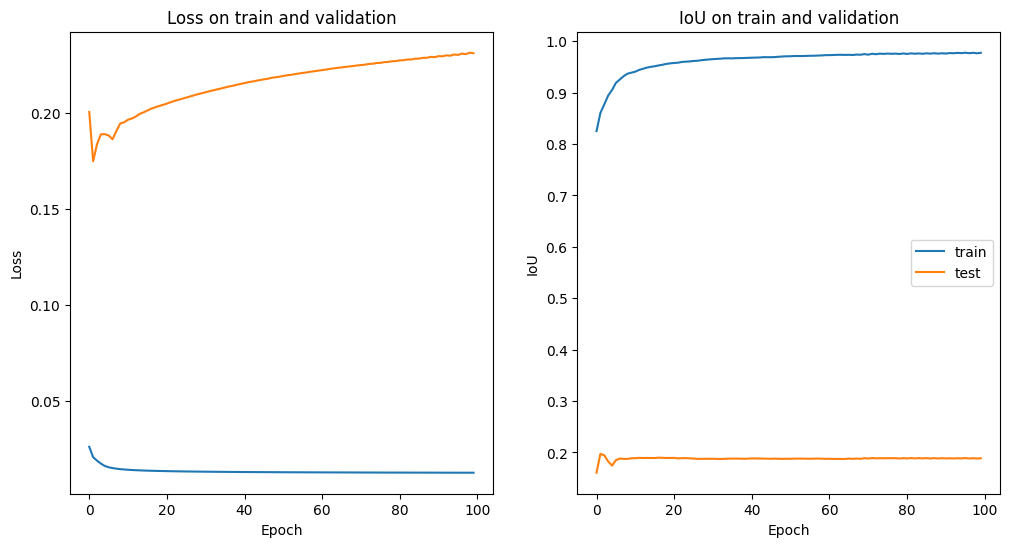

In [101]:
# создаём загрузчик
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=8)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=8)
train_losses, val_losses, train_iou, val_iou = train_loop(model, test_data,
                                      train_dataloader, test_dataloader,
                                      max_epoch=100)
plot_loss_iou(train_losses, val_losses, train_iou, val_iou)

Каких результатов удалось достичь с помощью неглубокой сети? Напишите вывод по графику и примерам изображения.

**Вывод**: модель нео

### 3. Реализация модели U-Net

Реализуйте модель U-Net ниже, дописав пропущенные части кода.

In [ ]:
def conv_bn_relu(in_channels, out_channels, kernel=3, stride=1, padding=1):
    net = nn.Sequential(
        nn.Conv2d(in_channels, out_channels,
                  kernel_size=kernel, stride=stride, padding=padding),
        nn.BatchNorm2d(num_features=out_channels),
        nn.ReLU(inplace=True)
    )
    return net


class Stacked2ConvsBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Stacked2ConvsBlock, self).__init__()
        self.blocks = nn.Sequential(
            conv_bn_relu(in_channels, out_channels),
            conv_bn_relu(out_channels, out_channels)
        )

    def forward(self, net):
        net = self.blocks(net)
        return net


class UpSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpSamplingBlock, self).__init__()

        # Понижаем число каналов
        self.upsample = nn.ConvTranspose2d(
            in_channels, in_channels, kernel_size=2, stride=2)

        # Стакаем с симметричным слоем из левой половины "U".
        # Число каналов входной карты при этом удваивается.
        self.convolve = Stacked2ConvsBlock(2 * in_channels, out_channels)

    def forward(self, left_net, right_net):
        right_net = self.upsample(right_net)
        # конкатенируем векторы из левой и правой половины
        net = <ваш код>
        # применяем свертку
        net = <ваш код>
        return net


class DownSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownSamplingBlock, self).__init__()
        self.blocks = nn.Sequential(
            nn.MaxPool2d(2, 2),
            Stacked2ConvsBlock(in_channels, out_channels)
        )

    def forward(self, net):
        return self.blocks(net)


class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        self.init_conv = Stacked2ConvsBlock(3, 64)

        self.downsample_1 = DownSamplingBlock(64, 128)
        self.downsample_2 = DownSamplingBlock(128, 256)
        self.downsample_3 = DownSamplingBlock(256, 512)
        self.downsample_4 = DownSamplingBlock(512, 1024)

        # В середине есть блок без пары с 1024 каналами
        # с ним конкатенировать некого, потому просто свернём его
        self.upconv = Stacked2ConvsBlock(1024, 512)

        # Подъём. Аналогично.
        self.upsample_1 = UpSamplingBlock(512, 256)
        self.upsample_2 = UpSamplingBlock(256, 128)
        self.upsample_3 = UpSamplingBlock(128, 64)
        # Чтобы учесть входной слой после самой первой свёртки и согласовать размерности
        self.upsample_4 = UpSamplingBlock(64, 64)

        # Предсказание
        self.agg_conv = nn.Sequential(nn.Conv2d(64, 1, kernel_size=1), nn.Sigmoid())

    def forward(self, x):
        net0 = self.init_conv(x) # 3 --> 64

        net1 = self.downsample_1(net0) # 64 --> 128
        net2 = self.downsample_2(net1) # 128 --> 256
        net3 = self.downsample_3(net2) # 256 --> 512
        net = self.downsample_4(net3) # 512 --> 1024

        net = self.upconv(net) # 1024 --> 512

        net = self.upsample_1(net3, net) # 512 --> 256
        net = <ваш код> # 256 --> 128
        net = <ваш код> # 128 --> 64
        net = <ваш код> # 64 --> 64

        net = self.agg_conv(net) # 64 --> 1

        return net

### Обучение модели

Обучите полученную модель U-Net на датасете ногтей. Постройте аналогичные графики лосса и метрики качества. Выведите несколько изображений и полученных для них масок. Сравните результаты с сетью, построенной в предыдущем пункте задания.

In [ ]:
unet_model = Unet().to(device)

lr = 1e-4

# создаём оптимизатор
optimizer = <задайте оптимизатор>

# задаём функцию потерь
criterion = <задайте функцию потерь>

In [ ]:
train_losses, val_losses, train_iou, val_iou = train_loop(unet_model, test_data,
                                      train_dataloader, test_dataloader,
                                      max_epoch=35)
plot_loss_iou(train_losses, val_losses, train_iou, val_iou)

Сделайте выводы.

**Вывод**